# Data Science Term Project

## A K-NN Approach to Predicting Newsletter Subscription Among Minecraft Players Based on Age and Playtime 


- Name: Geoff Acabado
- Student number: 59285189
- DSCI 100 003

## I. Introduction
Video games have become a widespread form of entertainment, attracting millions of players across diverse demographics (Atske & Atske, 2024). Minecraft stands out as one of the most popular sandbox games, offering an open-ended world where players can build, explore, and interact (Cipollone, Schifter, & Moffat, 2014). In addition to being a popular game, Minecraft provides a rich source of behavioral data that can be leveraged for research in areas such as player engagement, user behavior analysis, and targeted marketing. 

In this project, we analyze gameplay data collected from a Minecraft research server hosted by a research group at the University of British Columbia (UBC). The group collected detailed logs of player behavior as participants interact with the game world. This data includes various features such as age, playtime, and whether or not a player has subscribed to a newsletter related to the game. 

By applying data science techniques to this data, we aim to explore whether certain player characteristics, specifically, age and amount of playtime, can be used to predict whether a player subscribes to the game-related newsletter. These two variables were chosen to be the explanatory variables that will train the classification model because they are the only numeric variables in the datasets provided. The insights from this analysis can assist the research team in better understanding the factors that drive player engagement and inform future recruitment and resource allocation strategies. **Table 1.1** shows each of the variables in the player.csv dataset and what do they mean. 

| Variable     | Type          | Description                                                                 |
|--------------|---------------|-----------------------------------------------------------------------------|
| Experience   | factor         | Experience level of player: beginner, amateur, regular, pro, veteran        |
| subscribe    | logical        | Whether the player is subscribed (TRUE/FALSE)                               |
| hashedEmail  | character      | Hashed email of player to protect privacy                                   |
| played_hours | double         | Number of hours played by players                                           |
| name         | character      | Name of the player                                                          |
| gender       | factor         | Gender identity: agender, male, female, non-binary, two-spirited, prefer not to say |
| Age          | double         | Age of the player in years                                                  |

**Table 1.1**

The table below shows a complete list of all the variables in the `player.csv` dataset used in this project.

As mentioned before, the only numerical variables here are age and playtime. An additional dataset contains session-level start and end time but is not utilized in this analysis as the player experience provides sufficient information for addressing the research question. **Code 0.1** contains the libraries that will be used in this project and **Code 0.2** loads the data that will be analyzed. 

In [27]:
#code 0.1
#Some libraries to install
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

# We need to set this seed so that all results in this notebook can be replicated
set.seed(9999)

In [29]:
#Code 0.2
# install the data needed
player_data = read_csv("players.csv")
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


### Data explorations

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


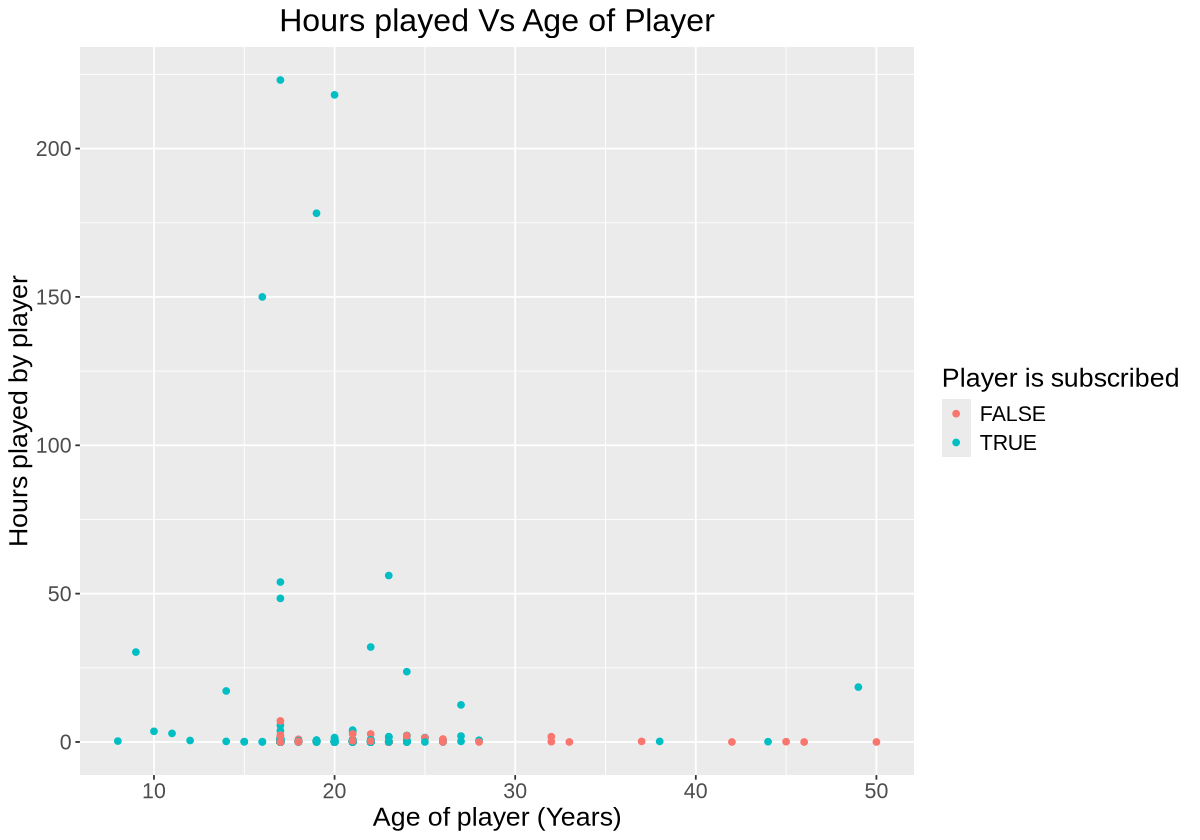

In [30]:
#Code 1.1
#Lets explore relationships between hours played, age and whether they are subscibed to game newspaper
options(repr.plot.height = 7, repr.plot.width = 10)
player_plot = player_data |>
    ggplot(aes(y = played_hours	, x = Age, color = subscribe)) +
    geom_point() +
    labs(
        title = "Hours played Vs Age of Player",
        y = "Hours played by player",
        x = "Age of player (Years)",
        colour = "Player is subscribed" ) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
player_plot

**Figure 1.1**

The plot above shows the relationship between the age of the player on the x-axis and the number of hours they have played Minecraft on the y-axis. Game-related newspaper subscriptions of each player are represented by the color of the points. Two datapoints are removed because the age of the player is unknown. 

The code above gave us a warning message indicating that there are 2 datapoints that have missing values or are out of range. In **code 1.15**, we show that these observations have unknown age and so were excluded from the ploting. One can see from **Figure 1.1** that most of the datapoints consist of players playing little to 0 hours in the game, making it difficult to make any inferences from the data. For this reason, the data was plotted on a logarithmic scale in **Figure 1.2** to magnify the subtleties in low values of hours played. 

In [34]:
#Code 1.15
missing_values = player_data |>
    filter(is.na(Age))
missing_values

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


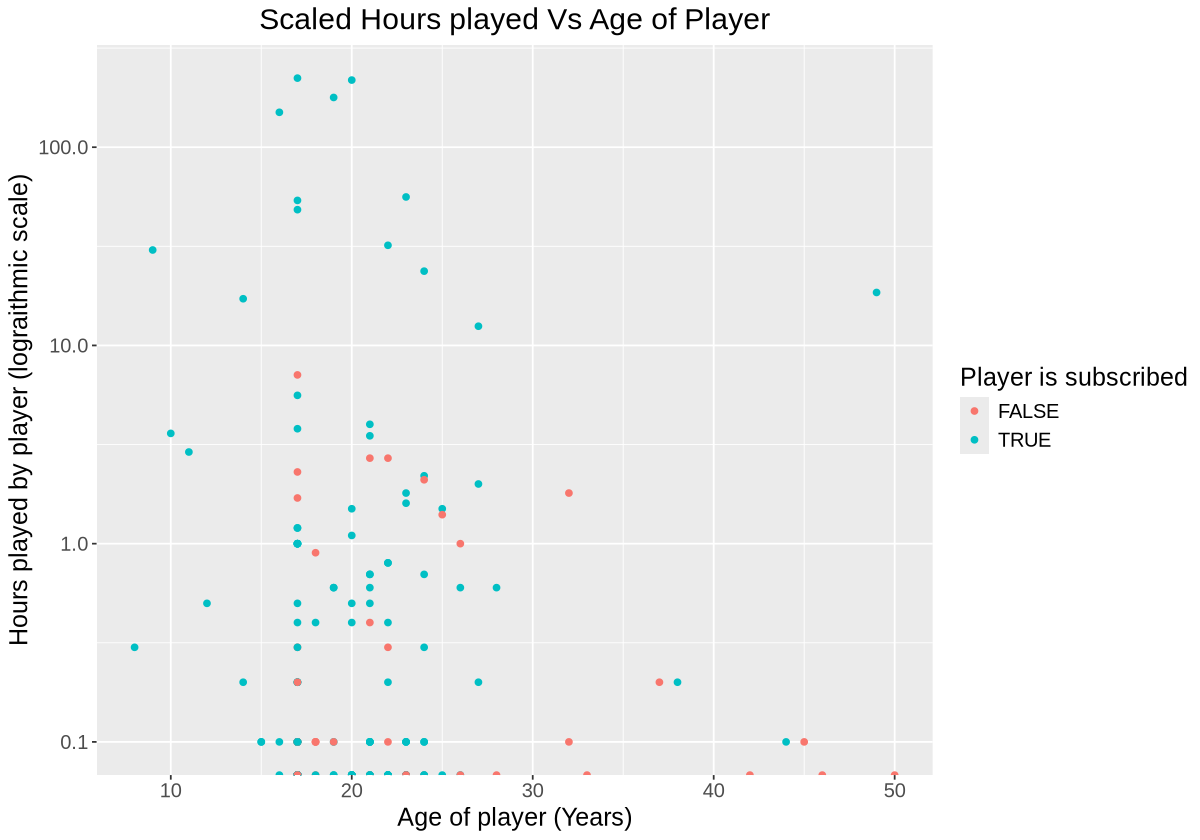

In [35]:
#Code 1.2
#Lets explore relationships between hours played, age and whether they are subscibed to game newspaper
player_plot_1 = player_data |>
    ggplot(aes(y = played_hours	, x = Age, color = subscribe)) +
    geom_point() +
    scale_y_log10() +
    labs(
        title = "Scaled Hours played Vs Age of Player",
        y = "Hours played by player (lograithmic scale)",
        x = "Age of player (Years)",
        colour = "Player is subscribed" ) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
player_plot_1



**Figure 1.2**

The scatter plot above shows the age of each player in the x-axis and the hours played on the y-axis but logarithmically scaled to show subtilities across different ranges. 

There was a warning that the logarithmic transformation turned the some 0s to infinity but it looks like it did not affect the purpose of our visualization that much. All of the supposedly 'negatively infinite' values remained at the bottom of the graph. From Figure 1.2, it can be easily observed that there is no obvious pattern between hours played by the player and their age. Both variables also do not seem to be correlated with whether the players are subscribed or not. However, it is important to notice that everyone who played for 10 hours or more is subscribed to a game newspaper. Another observation we see is that most players are around 15 to 25 years old, indicating that Minecraft is popular among this demographic

### II. Methods

The objective of this analysis is to build a classification model capable of predicting whether a player is subscribed to a gaming newspaper based on two predictor variables: the player’s total hours played (played_hours) and their age (Age). The response variable, subscribe, is a binary categorical variable indicating subscription status.

In [19]:
#Code 2.1
# Clean up data
player_data_clean = player_data |>
    select(subscribe, played_hours, Age) |>
    mutate(subscribe = as.factor(subscribe))

The data was first loaded and cleaned to retain only the relevant variables necessary for analysis. As shown in **Code 2.1**, we selected subscribe, played_hours, and Age from the original dataset. Since the classification model requires a categorical response variable, the subscribe column was converted into a factor. This ensured that the subsequent modeling functions would treat it appropriately as a classification target rather than a continuous variable. 

In [20]:
#Code 2.2
#split the data
player_data_split = initial_split(player_data_clean, prop = 0.7, strata = subscribe)
player_data_training = training(player_data_split)
player_data_testing = testing(player_data_split)

After cleaning the data, we partitioned the dataset into training and testing subsets to enable model evaluation of unseen data. Specifically, 70% of the data was randomly assigned to the training set, while the remaining 30% was reserved for testing **(Code 2.2)**. Stratified sampling was applied based on the subscribe variable to ensure that both classes were proportionally represented in each subset. This stratification helps prevent class imbalance from skewing model evaluation. 

In [21]:
#Code 2.3
# Tuning the model with 5 fold cross validation
player_data_vfold = vfold_cv(player_data_training, v = 5, strata = subscribe)

To optimize model performance, we used k-nearest neighbors (k-NN) classification, a non-parametric method well-suited for small- to medium-sized datasets with numeric predictors. To identify the optimal value of K, we applied five-fold cross-validation to the training set **(Code 2.3)**. The training data was randomly divided into five equal folds; during each iteration, one fold was used for validation while the remaining folds were used for training. This process was repeated five times, ensuring that each fold served as validation once.

In [22]:
#Code 2.4
#make recipe
player_data_recipe = recipe(subscribe ~., data = player_data_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Prior to modeling, the data was preprocessed using a recipe object in R **(Code 2.4)**. As k-NN is sensitive to the scale of the input features, both played_hours and Age were standardized via centering (subtracting the mean) and scaling (dividing by the standard deviation). This preprocessing step ensures that both predictors contribute equally to the distance calculations that underlie the k-NN algorithm. 

In [23]:
#Code 2.5
#Tune model
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [24]:
#Code 2.6
#Get results
k_vals = tibble(neighbors = 1:25)
knn_results = workflow() |>
    add_recipe(player_data_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_data_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy", !is.na(mean))

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 27 rows.
               ✖ Assigned data has 28 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 28 to size 27.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 26 rows.
               ✖ Assigned data has 27 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 27 to size 26.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

There were issues with some computations   A: x1   B: x1





During hyperparameter tuning, warnings related to row mismatches were encountered when certain K values exceeded the number of available observations within some cross-validation folds. These cases were automatically handled by the tuning procedure, and valid results were obtained for all feasible parameter combinations. Therefore, these warnings did not affect the final analysis.We then specified a k-NN model using the tidymodels framework **(Code 2.5)**. The number of neighbors (k) was treated as a tuning parameter to be optimized. We defined a grid search over K values ranging from 1 to 25 and fit the model using cross-validation resamples **(Code 2.6)**. The grid search evaluated model accuracy for each K, allowing us to identify the value of K that maximizes classification accuracy. 

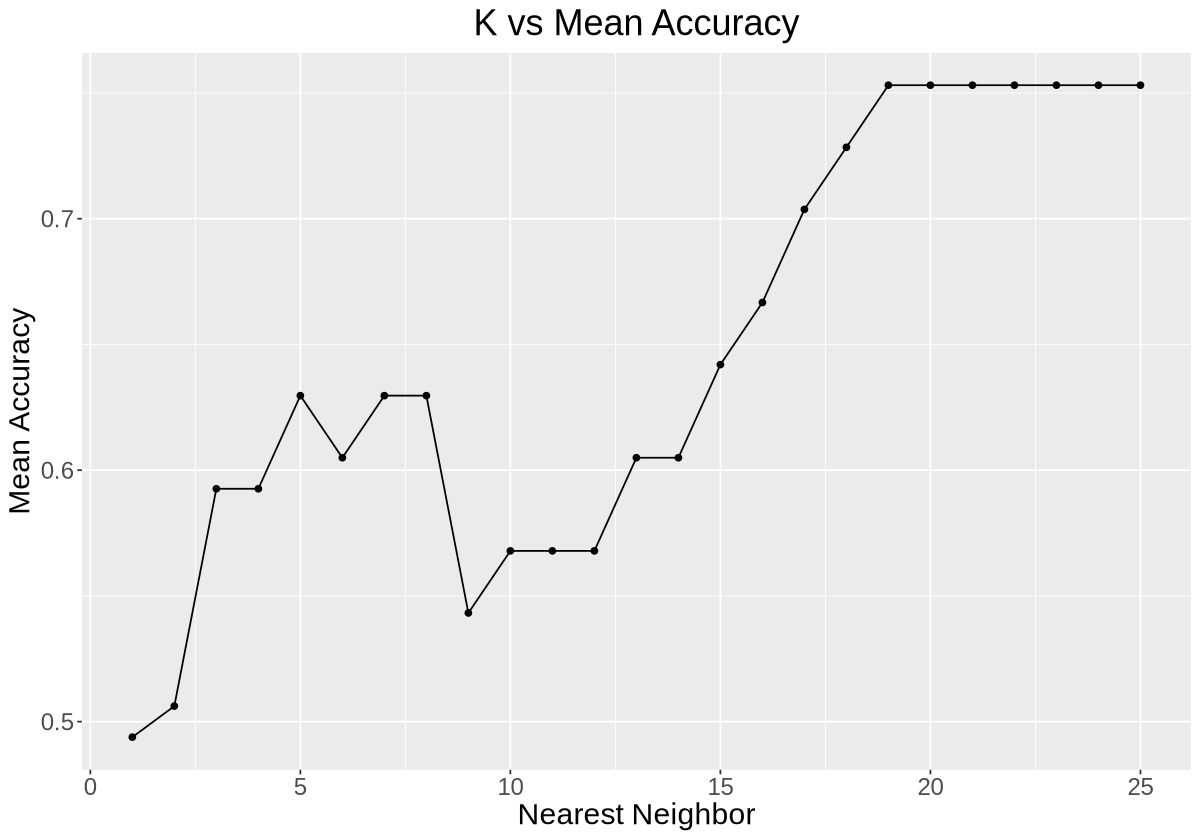

In [36]:
#Code 2.7
options(repr.plot.height = 7, repr.plot.width = 10)
knn_results_plot = knn_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Nearest Neighbor" , 
         y = "Mean Accuracy", 
         title = "K vs Mean Accuracy")+
    theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5))
knn_results_plot

**Figure 2.1**

The graph above shows the mean accuracy of the model for each value of k that was used. 

The results of the tuning process were visualized in Figure 2.1 to aid in model selection. As shown in **Code 2.7**, we plotted the mean cross-validation accuracy for each K value. This plot enabled us to visually assess which K values yielded the highest accuracy, helping the selection for the optimal neighborhood size for the final model. We see that there is a local maximum at K = 5 to 8 (excluding k = 6), which is probably the best K for this data set. We see that after K = 10, the accuracy increases again but that is probably just because there are a lot more people subscribed than not subscribed to newspaper. As K increases, the algorithm will just classify any point as "TRUE" which results in high accuracy but is not very useful in this context. For such a reason, a value of k = 7 was chosen for the model. Finally, after selecting the optimal K value, the final model will be fit on the full training set and evaluated on the testing set using metrics such as accuracy, precision, and recall assessing its practical utility in real-world 

### III. Results

In [38]:
#Code 3.1
# Create final model
final_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

final_fit <- workflow() |>
    add_recipe(player_data_recipe) |>
    add_model(final_spec) |>
    fit(data = player_data_training)

Using the results from the cross-validation tuning, we identified that a k value of 7 yielded the highest classification accuracy. We then built the final k-nearest neighbors classification model using this optimal value **(Code 3.1)**. The model was trained on the full training dataset, incorporating the same preprocessing steps of centering and scaling the predictor variables.

In [39]:
#Code 3.2
#Evaluate final model
test_predictions <- predict(final_fit, player_data_testing) |>
  bind_cols(player_data_testing)

In [40]:
#Code 3.3
#print the different metrics to asses the overall quality of the model
eval_metrics <- bind_rows(
  accuracy(test_predictions, truth = subscribe, estimate = .pred_class),
  precision(test_predictions, truth = subscribe, estimate = .pred_class),
  recall(test_predictions, truth = subscribe, estimate = .pred_class),
)

eval_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6333333
precision,binary,0.3500000
recall,binary,0.4375000


Once trained, the final model was evaluated on the previously withheld testing dataset to assess its predictive performance on unseen data **(Code 3.2)**. The model predictions were compared to the actual subscription status of the players, and three commonly used classification metrics were calculated: accuracy, precision, and recall **(Code 3.3)**. **Table 2.1** summarizes the results. 


| Metric    | Estimate |
|-----------|----------|
| accuracy  | 0.63     |
| precision | 0.35     |
| recall    | 0.48     |

**Table 2.1**

The table above shows a summary of the metrics used to assess the overall quality of the model. It contains calculated accuracy, precision, and recall of the model when applied to the testing dataset. 

### IV. Discussion
In this study, we developed a classification model to predict whether a player is subscribed to a gaming newspaper based on their age and hours played. After tuning the k-nearest neighbors (k-NN) algorithm using five-fold cross-validation, we identified that a k value of 7 provided the highest classification accuracy. When evaluated on the testing set, the final model achieved an accuracy of approximately 63.3%, with a precision of 35.0% and a recall of 43.8%. 

While the model demonstrated some ability to correctly classify subscription status, its moderate precision and recall indicate that its predictions are still limited. The accuracy slightly exceeds what would be expected by random guessing, suggesting that age and hours played contain some information relevant to subscription behavior. However, these two variables alone may not fully capture the complexity of a player's decision to subscribe. Many other unobserved factors such as personal interests, income, social influences, or engagement with game-related content may play a substantial role but are not included in the program. Another limitation of this study is the lack of data; with our sample only containing 194 complete observations. 

The choice of k-NN for this analysis was appropriate because the problem involved classifying observations into one of two categories based on continuous numeric predictors. k-NN makes minimal assumptions about the underlying data distribution, which is advantageous in cases where the true relationship between predictors and outcome may not be easily modeled parametrically. However, k-NN does have certain limitations: its performance can degrade with highly imbalanced classes or irrelevant predictors, and it is sensitive to the scaling of variables hence the need for preprocessing. Moreover, the method does not automatically provide insight into feature importance or underlying causal relationships. Cross-validation was essential to mitigate the risk of overfitting and ensure that the selected model generalized well to new data. 

The findings align partly with expectations: we anticipated that there may be some relationship between game engagement (hours played) and subscription behavior, but that predicting subscription status would likely be challenging with only these two predictors. The moderate performance metrics confirm this intuition. 

These findings suggest that while age and hours played offer some predictive value, additional variables are needed for a stronger subscription prediction model. Such a model could help gaming companies target potential subscribers more effectively. Future work could explore incorporating behavioral features, testing alternative modeling techniques, and examining how player behavior evolves over time.

### V. References
[ 1] Atske, S., & Atske, S. (2024, May 9). Teens and video games today. Pew Research Center. https://www.pewresearch.org/internet/2024/05/09/teens-and-video-games-today/#:~:text=Playing%20video%20games%20is%20widespread,23%2C%202023. 


[2] Cipollone, Maria & Schifter, Catherine & Moffat, Rick. (2014). Minecraft as a Creative Tool: A Case Study. International Journal of Game-Based Learning. 4. 1-14. 10.4018/ijgbl.2014040101. 